# Training and deploying a tabular model using Vertex custom training job

![Training pipeline](../images/custom-tabular.png)

In [1]:
import os
import pprint
import pandas as pd
import tensorflow as tf
import time

import matplotlib.pyplot as plt

from google.cloud import aiplatform as vertex_ai
from google.cloud.aiplatform_v1beta1 import types
from google.cloud import bigquery
from google.cloud import exceptions

from google.cloud.aiplatform.utils import JobClientWithOverride

from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow_io import bigquery as tfio_bq


## Configure GCP settings

*Before running the notebook make sure to follow the repo's README file to install the pre-requisites and configure GCP authentication.*

In [2]:
PROJECT = 'jk-mlops-dev'
REGION = 'us-central1'
STAGING_BUCKET = 'gs://jk-vertex-workshop-bucket'
VERTEX_SA = 'vertex-sa@jk-mlops-dev.iam.gserviceaccount.com'

## Preparing training data in BigQuery

### Explore Chicago Taxi dataset

In [3]:
%%bigquery data

SELECT 
    *
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
LIMIT 3

Downloading: 100%|██████████| 3/3 [00:01<00:00,  2.61rows/s]


In [4]:
data.head().T

,0,1,2
unique_key,d1c0e6541df70f7d76c58bd443cf911f038b7412,4155e838b1eecbc2a6634a90d1b639505ed9e19b,40228f36afe0c48983689c949d7e279ca8e8e9c7
taxi_id,fca0a720a85dda59406a7cb83b958b77c587e03c503c41...,487b08bac958b7e35025681d6ab2f21cd1e380f995fee0...,6fddf42c6f6cf22bcced14d3520b8218488737fe3d6212...
trip_start_timestamp,2014-10-31 06:45:00+00:00,2019-12-22 08:45:00+00:00,2019-12-01 20:00:00+00:00
trip_end_timestamp,2014-10-31 07:00:00+00:00,2019-12-22 09:00:00+00:00,2019-12-01 20:00:00+00:00
trip_seconds,780,1343,420
trip_miles,3.4,17.61,1.2
pickup_census_tract,NaN,NaN,NaN
dropoff_census_tract,NaN,NaN,NaN
pickup_community_area,NaN,NaN,NaN
dropoff_community_area,NaN,NaN,NaN


In [5]:
%%bigquery data

SELECT 
    CAST(EXTRACT(DAYOFWEEK FROM trip_start_timestamp) AS string) AS trip_dayofweek, 
    FORMAT_DATE('%A',cast(trip_start_timestamp as date)) AS trip_dayname,
    COUNT(*) as trip_count,
FROM `bigquery-public-data.chicago_taxi_trips.taxi_trips`
WHERE
    EXTRACT(YEAR FROM trip_start_timestamp) = 2015 
GROUP BY
    trip_dayofweek,
    trip_dayname
ORDER BY
    trip_dayofweek

Downloading: 100%|██████████| 7/7 [00:01<00:00,  6.78rows/s]


In [6]:
data

,trip_dayofweek,trip_dayname,trip_count
0,1,Sunday,4141154
1,2,Monday,4105900
2,3,Tuesday,4378805
3,4,Wednesday,4542810
4,5,Thursday,4918190
5,6,Friday,5289830
6,7,Saturday,5009186


<AxesSubplot:xlabel='trip_dayname'>

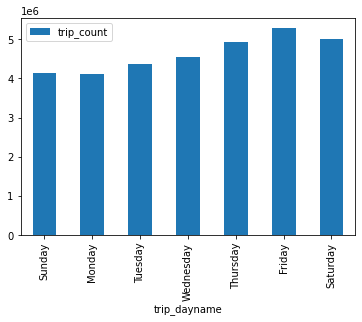

In [7]:
data.plot(kind='bar', x='trip_dayname', y='trip_count')

### Create  data splits

In [8]:
BQ_DATASET_NAME = 'chicago_taxi_training' # Change to your BQ datasent name.
BQ_TABLE_NAME = 'chicago_trips'
BQ_LOCATION = 'US'

#### Create a BQ dataset to host the splits

In [9]:
client = bigquery.Client()

dataset_id = f'{PROJECT}.{BQ_DATASET_NAME}'
dataset = bigquery.Dataset(dataset_id)
dataset.location = BQ_LOCATION

try:
    dataset = client.create_dataset(dataset, timeout=30)
    print('Created dataset: ', dataset_id)
except exceptions.Conflict:
    print('Dataset {} already exists'.format(dataset_id))

Dataset jk-mlops-dev.chicago_taxi_training already exists


#### Create a table with training features

In [10]:
sample_size = 1000000
year = 2020

sql_script_template = '''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@TABLE` 
AS (
    WITH
      taxitrips AS (
      SELECT
        FORMAT_DATETIME('%Y-%d-%m', trip_start_timestamp) AS date,
        trip_start_timestamp,
        trip_seconds,
        trip_miles,
        payment_type,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude,
        tips,
        fare
      FROM
        `bigquery-public-data.chicago_taxi_trips.taxi_trips`
      WHERE 1=1 
      AND pickup_longitude IS NOT NULL
      AND pickup_latitude IS NOT NULL
      AND dropoff_longitude IS NOT NULL
      AND dropoff_latitude IS NOT NULL
      AND trip_miles > 0
      AND trip_seconds > 0
      AND fare > 0
      AND EXTRACT(YEAR FROM trip_start_timestamp) = @YEAR
    )

    SELECT
      trip_start_timestamp,
      EXTRACT(MONTH from trip_start_timestamp) as trip_month,
      EXTRACT(DAY from trip_start_timestamp) as trip_day,
      EXTRACT(DAYOFWEEK from trip_start_timestamp) as trip_day_of_week,
      EXTRACT(HOUR from trip_start_timestamp) as trip_hour,
      trip_seconds,
      trip_miles,
      payment_type,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(pickup_longitude, pickup_latitude), 0.1)
      ) AS pickup_grid,
      ST_AsText(
          ST_SnapToGrid(ST_GeogPoint(dropoff_longitude, dropoff_latitude), 0.1)
      ) AS dropoff_grid,
      ST_Distance(
          ST_GeogPoint(pickup_longitude, pickup_latitude), 
          ST_GeogPoint(dropoff_longitude, dropoff_latitude)
      ) AS euclidean,
      IF((tips/fare >= 0.2), 1, 0) AS tip_bin,
      CASE (ABS(MOD(FARM_FINGERPRINT(date),10))) 
          WHEN 9 THEN 'testing'
          WHEN 8 THEN 'validation'
          ELSE 'training' END AS data_split
    FROM
      taxitrips
    LIMIT @LIMIT
)
'''

sql_script = sql_script_template.replace(
    '@PROJECT', PROJECT).replace(
    '@DATASET', BQ_DATASET_NAME).replace(
    '@TABLE', BQ_TABLE_NAME).replace(
    '@YEAR', str(year)).replace(
    '@LIMIT', str(sample_size))

job = client.query(sql_script)
job.result()

#### Review the created features

In [11]:
sql_script = f'''
SELECT * EXCEPT (trip_start_timestamp)
FROM {PROJECT}.{BQ_DATASET_NAME}.{BQ_TABLE_NAME} 
'''
df = client.query(sql_script).result().to_dataframe()

In [12]:
df.head().T

,0,1,2,3,4
trip_month,6,6,6,6,6
trip_day,19,19,19,19,19
trip_day_of_week,6,6,6,6,6
trip_hour,0,0,0,0,0
trip_seconds,240,1200,1780,660,900
trip_miles,0.9,4.1,9.64,1.1,0.4
payment_type,Cash,Cash,Prcard,Cash,Unknown
pickup_grid,POINT(-87.7 42),POINT(-87.6 41.8),POINT(-87.7 41.8),POINT(-87.7 41.9),POINT(-87.7 41.9)
dropoff_grid,POINT(-87.7 42),POINT(-87.7 41.9),POINT(-87.6 41.7),POINT(-87.6 41.9),POINT(-87.6 41.8)
euclidean,2406.040979,2210.049904,12414.729032,3788.78383,10666.168995


In [13]:
df.tip_bin.value_counts()

0    635470
1    364530
Name: tip_bin, dtype: int64

In [14]:
df.data_split.value_counts()

training      705807
validation    180636
testing       113557
Name: data_split, dtype: int64

### Create training, validation, and test splits

In [15]:
splits = ['training', 'validation', 'testing']

sql_script_template = f'''
CREATE OR REPLACE TABLE `@PROJECT.@DATASET.@VIEW`
AS
SELECT * EXCEPT (trip_start_timestamp, data_split)
FROM `@PROJECT.@DATASET.@TABLE`
WHERE data_split="@SPLIT"
'''

for split in splits:
    view_name = split + '_split'
    sql_script = sql_script_template.replace(
        '@PROJECT', PROJECT).replace(
        '@DATASET', BQ_DATASET_NAME).replace(
        '@TABLE', BQ_TABLE_NAME).replace(
        '@VIEW', view_name).replace(
        '@SPLIT', split)
    job = client.query(sql_script)
    job.result()

## Submitting Vertex training jobs

### Prepare a training script

In [16]:
SCRIPT_FOLDER = 'trainer'
if tf.io.gfile.exists(SCRIPT_FOLDER):
    tf.io.gfile.rmtree(SCRIPT_FOLDER)
tf.io.gfile.mkdir(SCRIPT_FOLDER)
file_path = os.path.join(SCRIPT_FOLDER, 'train.py')

In [17]:
%%writefile {file_path}


# Copyright 2021 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#            http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and

import os
import tensorflow as tf

from absl import app
from absl import flags
from absl import logging

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow_io import bigquery as tfio_bq


FLAGS = flags.FLAGS
flags.DEFINE_integer('epochs', 3, 'Nubmer of epochs')
flags.DEFINE_integer('units', 32, 'Number units in a hidden layer')
flags.DEFINE_integer('per_replica_batch_size', 128, 'Per replica batch size')
flags.DEFINE_float('dropout_ratio', 0.5, 'Dropout ratio')
flags.DEFINE_string('training_table', None, "Training table name")
flags.DEFINE_string('validation_table', None, "Validationa table name")
flags.mark_flag_as_required('training_table')
flags.mark_flag_as_required('validation_table')

LOCAL_MODEL_DIR = '/tmp/saved_model'
LOCAL_TB_DIR = '/tmp/logs'
LOCAL_CHECKPOINT_DIR = '/tmp/checkpoints'

FEATURES = {
    "tip_bin": ("categorical", tf.int64),
    "trip_month": ("categorical", tf.int64),
    "trip_day": ("categorical", tf.int64),
    "trip_day_of_week": ("categorical", tf.int64),
    "trip_hour": ("categorical", tf.int64),
    "payment_type": ("categorical", tf.string),
    "pickup_grid": ("categorical", tf.string),
    "dropoff_grid": ("categorical", tf.string),
    "euclidean": ("numeric", tf.double),
    "trip_seconds": ("numeric", tf.int64),
    "trip_miles": ("numeric", tf.double),
}

TARGET_FEATURE_NAME = "tip_bin"
TARGET_LABELS = ["tip<20%", "tip>=20%"]


def set_job_dirs():
    """Sets job directories based on env variables set by Vertex AI."""
    
    model_dir = os.getenv('AIP_MODEL_DIR', LOCAL_MODEL_DIR)
    tb_dir = os.getenv('AIP_TENSORBOARD_LOG_DIR', LOCAL_TB_DIR)
    checkpoint_dir = os.getenv('AIP_CHECKPOINT_DIR', LOCAL_CHECKPOINT_DIR)
    
    return model_dir, tb_dir, checkpoint_dir


def get_bq_dataset(table_name, selected_fields, target_feature='tip_bin', batch_size=32):
    
    def _transform_row(row_dict):
        trimmed_dict = {column:
                       (tf.strings.strip(tensor) if tensor.dtype == 'string' else tensor) 
                       for (column,tensor) in row_dict.items()
                       }
        target = trimmed_dict.pop(target_feature)
        return (trimmed_dict, target)

    project_id, dataset_id, table_id = table_name.split('.')
    
    client = tfio_bq.BigQueryClient()
    parent = f'projects/{project_id}'

    read_session = client.read_session(
        parent=parent,
        project_id=project_id,
        table_id=table_id,
        dataset_id=dataset_id,
        selected_fields=selected_fields,
    )

    dataset = read_session.parallel_read_rows().map(_transform_row).batch(batch_size)
    
    return dataset


def get_category_encoding_layer(name, dataset, dtype):
    """Creates a CategoryEncoding layer for a given feature."""

    if dtype == tf.string:
      index = preprocessing.StringLookup()
    else:
      index = preprocessing.IntegerLookup()

    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    return lambda feature: encoder(index(feature))


def get_normalization_layer(name, dataset):
  """"Creates a Normalization layer for a given feature."""
  normalizer = preprocessing.Normalization()

  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)

  return normalizer


def create_model(dataset, input_features, units, dropout_ratio):
    """Creates a binary classifier for Chicago Taxi tip prediction task."""
    
    all_inputs = []
    encoded_features = []
    for feature_name, feature_info in input_features.items():
        col = tf.keras.Input(shape=(1,), name=feature_name, dtype=feature_info[1])
        if feature_info[0] == 'categorical':
            
            encoding_layer = get_category_encoding_layer(feature_name, 
                                                         dataset,
                                                         feature_info[1])
        else:
            encoding_layer = get_normalization_layer(feature_name,
                                                     dataset) 
        encoded_col = encoding_layer(col)
        all_inputs.append(col)
        encoded_features.append(encoded_col)
        
    all_features = tf.keras.layers.concatenate(encoded_features)
    
    x = tf.keras.layers.Dense(units, activation="relu")(all_features)
    x = tf.keras.layers.Dropout(dropout_ratio)(x)
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(all_inputs, output)
    
    return model


def main(argv):
    del argv
    
    # Set distribution strategy
    strategy = tf.distribute.MirroredStrategy()
    
    global_batch_size = (strategy.num_replicas_in_sync *
                         FLAGS.per_replica_batch_size)
    
    # Prepare datasets
    selected_fields = {key: {'output_type': value[1]} for key, value in FEATURES.items()}
    validation_ds = get_bq_dataset(FLAGS.validation_table, 
                                   selected_fields, 
                                   batch_size=global_batch_size)
    training_ds = get_bq_dataset(FLAGS.training_table,
                                 selected_fields,
                                 batch_size=global_batch_size)
    
    # Prepare the model
    input_features = {key: value for key, value in FEATURES.items() if key != TARGET_FEATURE_NAME}
    logging.info('Creating the model ...')
    
    with strategy.scope():
        model = create_model(training_ds, input_features, FLAGS.units, FLAGS.dropout_ratio)
        model.compile(optimizer='adam',
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    # Configure Keras callbacks
    model_dir, tb_dir, checkpoint_dir = set_job_dirs()
    callbacks = [tf.keras.callbacks.experimental.BackupAndRestore(backup_dir=checkpoint_dir)]
    callbacks.append(tf.keras.callbacks.TensorBoard(
            log_dir=tb_dir, update_freq='batch'))
    
    logging.info('Starting training ...')
    model.fit(training_ds, 
              epochs=FLAGS.epochs, 
              validation_data=validation_ds,
              callbacks=callbacks)

       # Save trained model
    logging.info('Training completed. Saving the trained model to: {}'.format(model_dir))
    model.save(model_dir)  
    
if __name__ == '__main__':
    logging.set_verbosity(logging.INFO)
    app.run(main)

Writing trainer/train.py


### Initialize Vertex AI SDK

In [18]:
vertex_ai.init(
    project=PROJECT,
    location=REGION,
    staging_bucket=STAGING_BUCKET
)

### Create or set Tensorboard

In [19]:
tb_client = api_client = vertex_ai.initializer.global_config.create_client(
        client_class=vertex_ai.utils.TensorboardClientWithOverride, location_override=REGION
)
parent = f'projects/{PROJECT}/locations/{REGION}'

tensorboard_display_name = 'Workshop Tensorboard'
tensorboard_ref = None

for tensorboard in tb_client.list_tensorboards(parent=parent):
    if tensorboard.display_name == tensorboard_display_name:
        tensorboard_ref = tensorboard
        
if not tensorboard_ref:
    print('Creating new Tensorboard')
    tb_specs = types.Tensorboard(
        display_name=tensorboard_display_name,
        description=tensorboard_display_name
    )
    operation = tb_client.create_tensorboard(parent=parent, tensorboard=tb_specs)
    tensorboard_ref = operation.result()
else:
    print('Using existing Tensorboard:', tensorboard_ref.name)

Using existing Tensorboard: projects/895222332033/locations/us-central1/tensorboards/7964545572260544512


### Configure and submit a custom Vertex job using a script

In [20]:
job_name = job_name = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))
base_output_dir = f'{STAGING_BUCKET}/jobs/{job_name}'

container_uri = 'us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-4:latest'
requirements = ['tensorflow-datasets==4.3.0']
args = [
    '--epochs=3', 
    '--per_replica_batch_size=128',
    '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.training_split',
    '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.validation_split',
    
]

machine_type = 'n1-standard-4'
accelerator_type = 'NVIDIA_TESLA_T4'
accelerator_count = 1

job = vertex_ai.CustomJob.from_local_script(
    display_name=job_name,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    script_path='trainer/train.py',
    container_uri=container_uri,
    requirements=requirements,
    args=args,
    staging_bucket=f'{STAGING_BUCKET}/{job_name}'
)

job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=tensorboard_ref.name,
        )

INFO:google.cloud.aiplatform.utils.source_utils:Training script copied to:
gs://jk-vertex-workshop-bucket/JOB_20210605_144141/aiplatform-2021-06-05-14:41:42.176-aiplatform_custom_trainer_script-0.1.tar.gz.
INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/895222332033/locations/us-central1/customJobs/703269627358085120
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/895222332033/locations/us-central1/customJobs/703269627358085120')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/703269627358085120?project=895222332033
INFO:google.cloud.aiplatform.jobs:CustomJob projects/895222332033/locations/us-central1/customJobs/703269627358085120 current state:
JobState.JOB_STATE_QUEUED


### Configure and submit a Vertex job using a custom container

#### Create a docker file

In [21]:
BASE_IMAGE = 'gcr.io/deeplearning-platform-release/tf2-gpu.2-5'
TRAIN_IMAGE = f'gcr.io/{PROJECT}/taxi_classifier_trainer'

dockerfile = f'''
FROM {BASE_IMAGE}

WORKDIR /trainer

# Copies the trainer code to the docker image.
COPY train.py .

ENTRYPOINT ["python"]
CMD ["-c", "print('Hello')"]
'''

with open(os.path.join(SCRIPT_FOLDER, 'Dockerfile'), 'w') as f:
    f.write(dockerfile)

#### Build a container image

In [22]:
!gcloud builds submit --tag {TRAIN_IMAGE} {SCRIPT_FOLDER}

Creating temporary tarball archive of 2 file(s) totalling 7.1 KiB before compression.
Uploading tarball of [trainer] to [gs://jk-mlops-dev_cloudbuild/source/1622904117.191385-e34006d14df64fd5ad736e8d4f2029ab.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jk-mlops-dev/locations/global/builds/8bb57e16-e2a9-49af-9857-9fdca4c258d1].
Logs are available at [https://console.cloud.google.com/cloud-build/builds/8bb57e16-e2a9-49af-9857-9fdca4c258d1?project=895222332033].
INFO:google.cloud.aiplatform.jobs:CustomJob projects/895222332033/locations/us-central1/customJobs/703269627358085120 current state:
JobState.JOB_STATE_PENDING
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "8bb57e16-e2a9-49af-9857-9fdca4c258d1"

FETCHSOURCE
Fetching storage object: gs://jk-mlops-dev_cloudbuild/source/1622904117.191385-e34006d14df64fd5ad736e8d4f2029ab.tgz#1622904117456277
Copying gs://jk-mlops-dev_cloudbuild/source/1622904117.191385-e34006d14df64fd5ad

#### Prepare worker pool specification

In [27]:
worker_pool_specs =  [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4",
            "accelerator_type": "NVIDIA_TESLA_T4",
            "accelerator_count": 1,
        },
        "replica_count": 1,
        "container_spec": {
            "image_uri": TRAIN_IMAGE,
            "command": ["python", "train.py"],
            "args": [
                '--epochs=2', 
                '--per_replica_batch_size=128',
                '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.training_split',
                '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.validation_split',
            ],
        },
    }
]

#### Submit and monitor the job

In [28]:
job_name = "JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))

job = vertex_ai.CustomJob(
    display_name=job_name,
    worker_pool_specs=worker_pool_specs,
    staging_bucket=f'{STAGING_BUCKET}/{job_name}'
)

job.run(sync=False, 
        service_account=VERTEX_SA,
        tensorboard=tensorboard_ref.name)

INFO:google.cloud.aiplatform.jobs:Creating CustomJob
INFO:google.cloud.aiplatform.jobs:CustomJob created. Resource name: projects/895222332033/locations/us-central1/customJobs/5254720000769392640
INFO:google.cloud.aiplatform.jobs:To use this CustomJob in another session:
INFO:google.cloud.aiplatform.jobs:custom_job = aiplatform.CustomJob.get('projects/895222332033/locations/us-central1/customJobs/5254720000769392640')
INFO:google.cloud.aiplatform.jobs:View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/5254720000769392640?project=895222332033
INFO:google.cloud.aiplatform.jobs:CustomJob projects/895222332033/locations/us-central1/customJobs/5254720000769392640 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/895222332033/locations/us-central1/customJobs/5254720000769392640 current state:
JobState.JOB_STATE_PENDING
INFO:google.cloud.aiplatform.jobs:CustomJob projects/895222332033/locations/us-central1/

### Configure and submit a hyperparameter job

In [43]:
job_name = "HYPER_JOB_{}".format(time.strftime("%Y%m%d_%H%M%S"))

hyperparameter_tuning_job_spec = {
        "display_name": job_name,
        "max_trial_count": 6,
        "parallel_trial_count": 2,
        "max_failed_trial_count": 1,
        "study_spec": {
            "metrics": [
                {
                    "metric_id": "accuracy",
                    "goal": vertex_ai.gapic.StudySpec.MetricSpec.GoalType.MAXIMIZE,
                }
            ],
            "parameters": [
                {
                    "parameter_id": "units",
                    "discrete_value_spec": {"values": [32, 64]},
                },
                {
                    "parameter_id": "dropout_ratio",
                    "double_value_spec": {"min_value": 0.4, "max_value": 0.6},
                }
            ],
        },
        "trial_job_spec": {
            "base_output_directory": {
                "output_uri_prefix": f"{STAGING_BUCKET}/{job_name}"
            },
            "worker_pool_specs": [
                {
                    "machine_spec": {
                        "machine_type": "n1-standard-4",
                        "accelerator_type": vertex_ai.gapic.AcceleratorType.NVIDIA_TESLA_T4,
                        "accelerator_count": 1,
                    },
                    "replica_count": 1,
                    "container_spec": {
                        "image_uri": TRAIN_IMAGE,
                        "command": ["python", "train.py"],
                        "args": [
                            '--epochs=2', 
                            '--per_replica_batch_size=128',
                            '--training_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.training_split',
                            '--validation_table=' + f'{PROJECT}.{BQ_DATASET_NAME}.validation_split',
                        ],
                    },
                }
            ]
        },
    }


In [44]:
job_client = api_client = vertex_ai.initializer.global_config.create_client(
        client_class=JobClientWithOverride, location_override=REGION
)

parent = f'projects/{PROJECT}/locations/{REGION}'

response = job_client.create_hyperparameter_tuning_job(
    parent=parent, hyperparameter_tuning_job=hyperparameter_tuning_job_spec
)

response: name: "projects/895222332033/locations/us-central1/hyperparameterTuningJobs/6331080311710941184"
display_name: "HYPER_JOB_20210605_154300"
study_spec {
  metrics {
    metric_id: "accuracy"
    goal: MAXIMIZE
  }
  parameters {
    parameter_id: "units"
    discrete_value_spec {
      values: 32.0
      values: 64.0
    }
  }
  parameters {
    parameter_id: "dropout_ratio"
    double_value_spec {
      min_value: 0.4
      max_value: 0.6
    }
  }
}
max_trial_count: 6
parallel_trial_count: 2
max_failed_trial_count: 1
trial_job_spec {
  worker_pool_specs {
    machine_spec {
      machine_type: "n1-standard-4"
      accelerator_type: NVIDIA_TESLA_T4
      accelerator_count: 1
    }
    replica_count: 1
    disk_spec {
      boot_disk_type: "pd-ssd"
      boot_disk_size_gb: 100
    }
    container_spec {
      image_uri: "gcr.io/jk-mlops-dev/taxi_classifier_trainer"
      command: "python"
      command: "train.py"
      args: "--epochs=2"
      args: "--per_replica_batch_size

### Monitor the job

In [48]:
job_spec = job_client.get_hyperparameter_tuning_job(
    name = response.name
)
print(job_spec.state)

JobState.JOB_STATE_RUNNING


## Deploying a model to Vertex 

### Inspect the model

In [49]:
saved_model_path = 'gs://jk-vertex-workshop-bucket/models/taxi'

!saved_model_cli show --dir {saved_model_path} --tag_set serve --signature_def serving_default

2021-06-05 16:36:49.836264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_dropoff_grid:0
  inputs['euclidean'] tensor_info:
      dtype: DT_DOUBLE
      shape: (-1, 1)
      name: serving_default_euclidean:0
  inputs['payment_type'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_payment_type:0
  inputs['pickup_grid'] tensor_info:
      dtype: DT_STRING
      shape: (-1, 1)
      name: serving_default_pickup_grid:0
  inputs['trip_day'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day:0
  inputs['trip_day_of_week'] tensor_info:
      dtype: DT_INT64
      shape: (-1, 1)
      name: serving_default_trip_day_of_week:0
  inputs['trip_hour'] tensor_info:
      dtype:

### Upload the model

In [50]:
display_name = 'taxi-tip-classifier'
serving_image_uri = 'us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-4:latest'

model = vertex_ai.Model.upload(
    display_name=display_name,
    artifact_uri=saved_model_path,
    serving_container_image_uri=serving_image_uri
)

model.wait()

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/895222332033/locations/us-central1/models/1209225296042000384/operations/623572901408276480
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/895222332033/locations/us-central1/models/1209225296042000384
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/895222332033/locations/us-central1/models/1209225296042000384')


### Create an endpoint

In [55]:
display_name = 'taxi-endpoint'

endpoint = vertex_ai.Endpoint.create(display_name=display_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/895222332033/locations/us-central1/endpoints/5073920706744418304/operations/7716742314516807680
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/895222332033/locations/us-central1/endpoints/5073920706744418304
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/895222332033/locations/us-central1/endpoints/5073920706744418304')


### Deploy the Model

In [56]:
deployed_model_display_name = 'taxi-v1'
traffic_percentage = 100
machine_type = 'n1-standard-4'

endpoint = model.deploy(
        endpoint=endpoint,
        deployed_model_display_name=deployed_model_display_name,
        machine_type=machine_type,
        traffic_percentage=traffic_percentage)


INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/895222332033/locations/us-central1/endpoints/5073920706744418304
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/895222332033/locations/us-central1/endpoints/5073920706744418304/operations/7564745827093053440
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/895222332033/locations/us-central1/endpoints/5073920706744418304


## Invoking the deployed model using Vertex SDK

### Get the endpoint

In [57]:
for endpoint_info in vertex_ai.Endpoint.list(filter='display_name="taxi-endpoint"'):
    print(endpoint_info)
    
endpoint = vertex_ai.Endpoint(endpoint_info.resource_name)

resource name: projects/895222332033/locations/us-central1/endpoints/5073920706744418304


### Call the endpoint

In [58]:
test_instances = [  
    
    {
        "dropoff_grid": ["POINT(-87.6 41.9)"],
        "euclidean": [2064.2696],
        "payment_type": ["Credit Card"],
        "pickup_grid": ["POINT(-87.6 41.9)"],
        "trip_miles": [1.37],
        "trip_day": [12],
        "trip_hour": [16],
        "trip_month": [2],
        "trip_day_of_week": [4],
        "trip_seconds": [555]
    }
]

predictions = endpoint.predict(instances=test_instances)
prob = tf.nn.sigmoid(predictions[0])
print('Probability of tip > 20%:', prob.numpy())

Probability of tip > 20%: [[0.75511366]]


## Clean up

### Undeploy models

In [62]:
endpoint.list_models()

[id: "6844468678998622208"
model: "projects/895222332033/locations/us-central1/models/1209225296042000384"
display_name: "taxi-v1"
create_time {
  seconds: 1622911488
  nanos: 953563000
}
dedicated_resources {
  machine_spec {
    machine_type: "n1-standard-4"
  }
  min_replica_count: 1
  max_replica_count: 1
}
]

In [63]:
endpoint.undeploy_all()

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/895222332033/locations/us-central1/endpoints/5073920706744418304
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/895222332033/locations/us-central1/endpoints/5073920706744418304/operations/2301163762603786240
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/895222332033/locations/us-central1/endpoints/5073920706744418304


resource name: projects/895222332033/locations/us-central1/endpoints/5073920706744418304

### Delete endpoint

In [65]:
endpoint.delete()

INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/895222332033/locations/us-central1/endpoints/5073920706744418304
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/895222332033/locations/us-central1/operations/2247120567075340288
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/895222332033/locations/us-central1/endpoints/5073920706744418304


### Delete model

In [67]:
model.delete()

INFO:google.cloud.aiplatform.base:Deleting Model : projects/895222332033/locations/us-central1/models/1209225296042000384
INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/895222332033/locations/us-central1/operations/3316725478575833088
INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/895222332033/locations/us-central1/models/1209225296042000384
